In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
from pathlib import Path
import numpy as np
import pandas as pd
import os
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
output_dir = "/lustre/groups/ml01/workspace/ot_perturbation/analysis/combosciplex/embedding"
fig_dir = "/lustre/groups/ml01/workspace/ot_perturbation/figures/combosciplex/embedding"
data_dir = "/lustre/groups/ml01/workspace/ot_perturbation/analysis/combosciplex/embedding"


In [6]:
df_emb = pd.read_csv(os.path.join(data_dir, "cond_embedding_split_3.csv"))
df_emb = df_emb.set_index("condition")
df_emb = df_emb[[str(i) for i in np.arange(64)]]

In [7]:
split = 3

In [8]:
adata_pred_ood = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_ood_with_predictions_{split}.h5ad")


In [9]:
adata_pred_ood.X = adata_pred_ood.layers["X_recon_pred"]


In [10]:
vals = adata_pred_ood.X
vals[vals<0] = 0.0
adata_pred_ood.X = vals

In [11]:
adata_train_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_train_{split}.h5ad"
adata_test_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_test_{split}.h5ad"
adata_ood_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood_{split}.h5ad"

In [12]:
adata_train = sc.read(adata_train_path)
adata_test = sc.read(adata_test_path)
adata_ood = sc.read(adata_ood_path)

In [13]:
adata_pred_ood.var_names = adata_ood.var_names

In [14]:
adata_ood.obs["condition"].unique()

['control+Dacinostat', 'Panobinostat+Sorafenib', 'Panobinostat+SRT1720', 'Panobinostat+Crizotinib', 'control+Alvespimycin', 'Panobinostat+Curcumin', 'SRT2104+Alvespimycin', 'control']
Categories (8, object): ['Panobinostat+Crizotinib', 'Panobinostat+Curcumin', 'Panobinostat+SRT1720', 'Panobinostat+Sorafenib', 'SRT2104+Alvespimycin', 'control', 'control+Alvespimycin', 'control+Dacinostat']

In [15]:
adata_pred_ood.obs["condition"].unique()

['Panobinostat+Crizotinib', 'Panobinostat+Curcumin', 'Panobinostat+SRT1720', 'Panobinostat+Sorafenib', 'SRT2104+Alvespimycin', 'control+Alvespimycin', 'control+Dacinostat']
Categories (7, object): ['Panobinostat+Crizotinib', 'Panobinostat+Curcumin', 'Panobinostat+SRT1720', 'Panobinostat+Sorafenib', 'SRT2104+Alvespimycin', 'control+Alvespimycin', 'control+Dacinostat']

In [16]:
adata_full = ad.concat((adata_train, adata_test, adata_ood[adata_ood.obs["condition"]!="control"])) 

In [17]:
sc.tl.rank_genes_groups(adata_full, groupby="condition", reference="control")

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_g

In [18]:
df_logfoldchanges = sc.get.rank_genes_groups_df(adata_full, group=None)

In [19]:
df_upregulation = df_logfoldchanges[df_logfoldchanges["logfoldchanges"]>0].sort_values("pvals_adj", ascending=True)

In [20]:
df_downregulation = df_logfoldchanges[df_logfoldchanges["logfoldchanges"]<0].sort_values("pvals_adj", ascending=True)

In [21]:
df_logfoldchanges["condition_gene"] = df_logfoldchanges.apply(lambda x: x["group"] + "_" +  x["names"], axis=1)

In [22]:
df_logfoldchanges.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj,condition_gene
0,Alvespimycin+Pirarubicin,MALAT1,26.882980,0.870778,6.091306e-124,1.218261e-120,Alvespimycin+Pirarubicin_MALAT1
1,Alvespimycin+Pirarubicin,HSPA1A,24.885818,4.048759,7.185875e-99,3.592937e-96,Alvespimycin+Pirarubicin_HSPA1A
2,Alvespimycin+Pirarubicin,PDGFD,24.158207,3.917717,4.881118e-95,1.952447e-92,Alvespimycin+Pirarubicin_PDGFD
3,Alvespimycin+Pirarubicin,PTPRJ,21.789631,2.896154,4.910841e-87,1.636947e-84,Alvespimycin+Pirarubicin_PTPRJ
4,Alvespimycin+Pirarubicin,CYP4F3,19.645294,3.516851,6.596021e-68,1.319204e-65,Alvespimycin+Pirarubicin_CYP4F3


In [23]:
adata_pred = ad.concat((adata_pred_ood, adata_ood[adata_ood.obs["condition"]=="control"]))

In [24]:
adata_pred.obs["condition"].value_counts()

condition
Panobinostat+Crizotinib    500
Panobinostat+Curcumin      500
Panobinostat+SRT1720       500
Panobinostat+Sorafenib     500
SRT2104+Alvespimycin       500
control                    500
control+Alvespimycin       500
control+Dacinostat         500
Name: count, dtype: int64

In [25]:
adata_pred.X

<4000x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 5630988 stored elements in Compressed Sparse Row format>

In [26]:
sc.tl.rank_genes_groups(adata_pred, groupby="condition", groups="all", reference="control")

In [27]:
df_logfoldchanges_pred = sc.get.rank_genes_groups_df(adata_pred, group=None)

In [28]:
df_logfoldchanges_pred["condition_gene"] = df_logfoldchanges_pred.apply(lambda x: x["group"] + "_" +  x["names"], axis=1)

In [29]:
df_logfoldchanges_merged = pd.merge(df_logfoldchanges_pred, df_logfoldchanges, left_on="condition_gene", right_on="condition_gene", suffixes=("_pred", "_true"))

In [30]:
df_logfoldchanges_merged.shape

(14000, 13)

In [31]:
#df_logfoldchanges_merged = df_logfoldchanges_merged[~df_logfoldchanges_merged["logfoldchanges_pred"].isnull()]

In [32]:
for ood_cond in adata_ood.obs["condition"].unique():
    if ood_cond=="control":
        continue
    df_tmp = df_logfoldchanges_merged[df_logfoldchanges_merged["group_pred"]==ood_cond]
    df_tmp = df_tmp[df_tmp["names_pred"].isin(adata_train.uns["rank_genes_groups_cov_all"][ood_cond])]
    df_tmp.to_csv(os.path.join(output_dir, f"deg_{ood_cond}.csv"))

In [33]:
df_logfoldchanges_merged.to_csv("/lustre/groups/ml01/workspace/ot_perturbation/analysis/combosciplex/logfoldchanges_split_3.csv")

In [34]:
df_upregulation.to_csv("/lustre/groups/ml01/workspace/ot_perturbation/analysis/combosciplex/upregulated_genes_split_3.csv")
df_downregulation.to_csv("/lustre/groups/ml01/workspace/ot_perturbation/analysis/combosciplex/downregulated_genes_split_3.csv")

In [35]:


param_grid = {
    "linear": {
        'alpha': [0.1, 1, 10],
    },
    "poly": {
        'alpha': [0.1, 1, 10],
        'degree': [2, 3, 4, 5],
        'gamma': [0.1, 0.5, 1],
    },
    "rbf": {
        'alpha': [0.1, 1, 10],
        'gamma': [0.1, 0.5, 1],
    },
    "sigmoid": {
        'alpha': [0.1, 1, 10],
        'gamma': [0.1, 0.5, 1],
    },
        
}

    
def predict_linear(kernel, X_train, y_train, X_test, y_test):
    model = KernelRidge(kernel=kernel)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid[kernel], scoring='neg_mean_squared_error', cv=3, verbose=0, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    df_res = pd.DataFrame(data=np.concatenate((y_pred_train, y_pred_test)), columns=["predictions"])
    df_res["true"] = np.concatenate((y_train, y_test))
    df_res["mode"] = ["train"]* len(y_train) + ["test"] * len(y_test)
    return df_res



In [36]:
upreg_dict = {}
res_red = df_logfoldchanges[df_logfoldchanges.group.isin(adata_ood.obs["condition"].unique())]
for cond in res_red.group.unique():
    if "pred" in cond:
        continue
    upreg_dict[cond] = list(res_red[(res_red.logfoldchanges>0)&(res_red.group==cond)].sort_values("pvals_adj").iloc[:20].names)

In [37]:
downreg_dict = {}
res_red = df_logfoldchanges[df_logfoldchanges.group.isin(adata_ood.obs["condition"].unique())]
for cond in res_red.group.unique():
    if "pred" in cond:
        continue
    downreg_dict[cond] = list(res_red[(res_red.logfoldchanges<0)&(res_red.group==cond)].sort_values("pvals_adj").iloc[:20].names)

In [38]:
upreg_genes = set([el for it in upreg_dict.values() for el in it])
downreg_genes = set([el for it in downreg_dict.values() for el in it])
genes_selected = list(upreg_genes.union(downreg_genes))

In [39]:
ood_conditions=adata_ood.obs["condition"].unique()
def get_mode(x):
    if "pred" in x["condition"]:
        return "pred"
    if x["condition"] in ood_conditions:
        return "unseen"
    return "seen"
    
df_data = pd.DataFrame(columns=genes_selected)
for cond in df_logfoldchanges["group"].unique():
    if cond=="control":
        continue
    res_tmp = df_logfoldchanges[df_logfoldchanges["group"]==cond]
    df_data.loc[cond,:] = res_tmp[res_tmp["names"].isin(genes_selected)].set_index("names").loc[genes_selected]["logfoldchanges"]


df_data["condition"] = df_data.index
df_data["mode"] = df_data.apply(get_mode, axis=1)

df_seen = df_data[df_data["mode"]=="seen"]
df_unseen = df_data[df_data["mode"]=="unseen"]


In [40]:
pearson_result = {}
spearman_result = {}

df_seen = df_data[df_data["mode"]=="seen"]
df_unseen = df_data[df_data["mode"]=="unseen"]


for kernel in ["linear", "poly", "rbf", "sigmoid"]:
    pearson_result[kernel] = {}
    spearman_result[kernel] = {}
    for target_variable in genes_selected:
        X_train, X_test = df_emb.loc[df_seen.index].values, df_emb.loc[df_unseen.index].values
        y_train, y_test = df_seen[target_variable], df_unseen[target_variable]
        
        out = predict_linear(kernel, X_train, y_train, X_test, y_test)

        
        pearson_result[kernel][target_variable] = out[out["mode"]=="test"][["predictions", "true"]].corr("pearson").iloc[0,1]
        spearman_result[kernel][target_variable] = out[out["mode"]=="test"][["predictions", "true"]].corr("spearman").iloc[0,1]
        



/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singul

In [41]:
spearman_result["CellFlow"] = {}
pearson_result["CellFlow"] = {}
for gene in genes_selected:
    df_tmp = df_logfoldchanges_merged[df_logfoldchanges_merged["names_pred"]==gene]
    pearson_result["CellFlow"][gene] = df_tmp[["logfoldchanges_pred", "logfoldchanges_true"]].corr(method="pearson").iloc[0,1]
    spearman_result["CellFlow"][gene] = df_tmp[["logfoldchanges_pred", "logfoldchanges_true"]].corr(method="spearman").iloc[0,1]


In [42]:
df_pearson = pd.DataFrame.from_dict(pearson_result)

<Axes: >

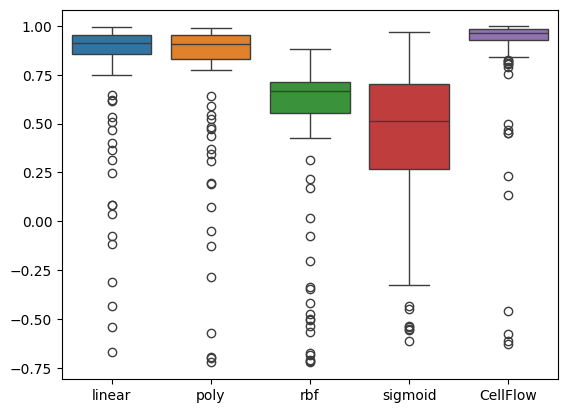

In [43]:
import seaborn as sns
sns.boxplot(df_pearson)

In [44]:
df_pearson.to_csv(os.path.join(output_dir, "aggregated_pearson.csv"))

In [45]:
df_pearson.mean(axis=0)

linear      0.781988
poly        0.764212
rbf         0.493131
sigmoid     0.420741
CellFlow    0.860405
dtype: float64

In [46]:
genes_selected = ['TFPI2', 'PTPRJ', "KYNU", "KRT7"]

In [47]:
result = {}

df_seen = df_data[df_data["mode"]=="seen"]
df_unseen = df_data[df_data["mode"]=="unseen"]
kernel = "linear"

pearson_result[kernel] = {}
spearman_result[kernel] = {}
for target_variable in genes_selected:
    X_train, X_test = df_emb.loc[df_seen.index].values, df_emb.loc[df_unseen.index].values
    y_train, y_test = df_seen[target_variable], df_unseen[target_variable]
    
    out = predict_linear(kernel, X_train, y_train, X_test, y_test)
    out.index = list(df_seen.index) + list(df_unseen.index)
    df_tmp = df_logfoldchanges_merged[df_logfoldchanges_merged["names_pred"]==target_variable]
    df_tmp = df_tmp[["logfoldchanges_pred", "group_pred"]].set_index("group_pred")
    df_tmp["true"] = out["true"]
    df_tmp["predictions"] = df_tmp["logfoldchanges_pred"]
    df_tmp["mode"] = "CF"
    df_all  = pd.concat((out, df_tmp))
    
    result[target_variable] = df_all
    
    



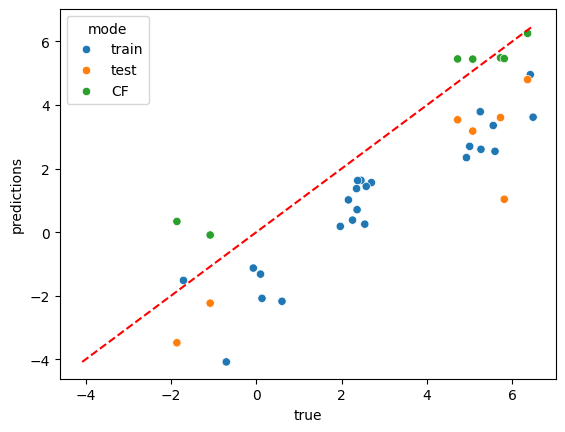

In [48]:
df_all = result[genes_selected[0]]
sns.scatterplot(df_all, x="true", y="predictions", hue="mode")
mi = min(df_all['true'].min(), df_all['predictions'].min())
ma = max(df_all['true'].max(), df_all['predictions'].max())

plt.plot([mi, ma], 
         [mi, ma], 
         color='red', linestyle='--', label='y=x')

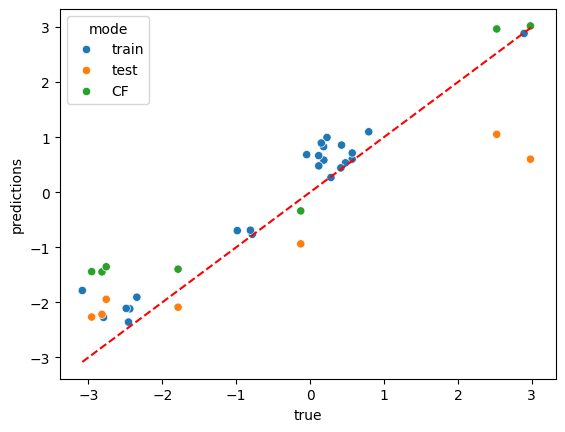

In [49]:
df_all = result[genes_selected[1]]
sns.scatterplot(df_all, x="true", y="predictions", hue="mode")
mi = min(df_all['true'].min(), df_all['predictions'].min())
ma = max(df_all['true'].max(), df_all['predictions'].max())

plt.plot([mi, ma], 
         [mi, ma], 
         color='red', linestyle='--', label='y=x')

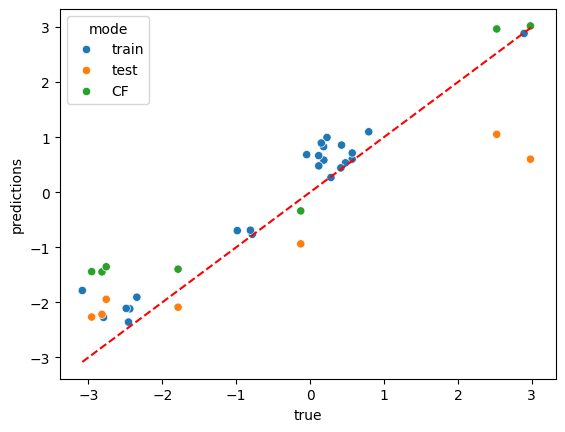

In [50]:
df_all = result[genes_selected[1]]
sns.scatterplot(df_all, x="true", y="predictions", hue="mode")
mi = min(df_all['true'].min(), df_all['predictions'].min())
ma = max(df_all['true'].max(), df_all['predictions'].max())

plt.plot([mi, ma], 
         [mi, ma], 
         color='red', linestyle='--', label='y=x')

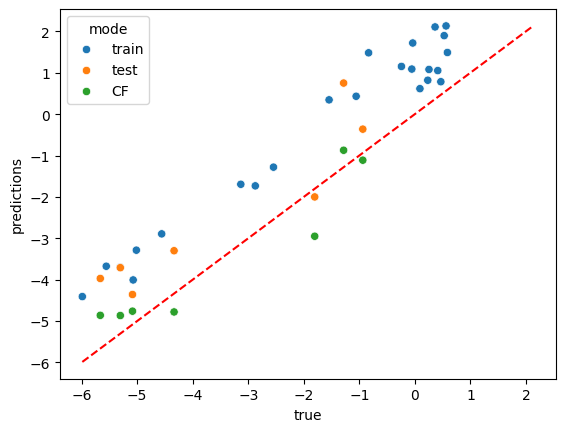

In [51]:
df_all = result[genes_selected[3]]
sns.scatterplot(df_all, x="true", y="predictions", hue="mode")
mi = min(df_all['true'].min(), df_all['predictions'].min())
ma = max(df_all['true'].max(), df_all['predictions'].max())

plt.plot([mi, ma], 
         [mi, ma], 
         color='red', linestyle='--', label='y=x')

In [52]:
result["TFPI2"].to_csv(os.path.join(output_dir, "TFPI2_logfold.csv"))
result["PTPRJ"].to_csv(os.path.join(output_dir, "PTPRJ_logfold.csv"))
result["KYNU"].to_csv(os.path.join(output_dir, "KYNU_logfold.csv"))
result["KRT7"].to_csv(os.path.join(output_dir, "KRT7_logfold.csv"))

'control+Dacinostat':

TFPI2: https://www.sciencedirect.com/science/article/pii/S0169500211004715 (down)
MALAT1-1: https://ncbi.nlm.nih.gov/gene/72289 (down)
TUBA1B: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10369087/ (up)

'Panobinostat+Sorafenib':

COL26A1 (down)
TFPI2: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3722576/ (down)
AKR1B10: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6209774/ (up)

'Panobinostat+SRT1720':

COL26A1 (down)
TFPI2 (down)